In [58]:
import eniric
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from eniric.atmosphere import Atmosphere
from eniric.Qcalculator import rv_precision
from eniric.Qcalculator import quality
import colorful as cl
%matplotlib notebook

In [30]:
hdu = fits.open('car-20160325T05h28m38s-sci-gtoc-nir_A_input_TAC.fits')
data_tell = hdu[1].data
wave = data_tell['WAVE'] *0.0001  #(nm)
flux_in = data_tell['SPEC']
flux_corr = data_tell['tacflux']
trans = data_tell['mtrans']
wave

array([0.96035719, 0.96036253, 0.96036786, ..., 1.71183439, 1.71183983,
       1.71184527])

input flux, atm mask:  3760.160247909164 m / s  > masking the tellurics
corr flux, trans mask: 3188.871903032806 m / s  > telluric correction

Quality
input flux, atm mask:  1887.9268231003489 
corr flux, trans mask: 2198.893388603369
ATM mask [ True  True  True ...  True  True  True]


<IPython.core.display.Javascript object>


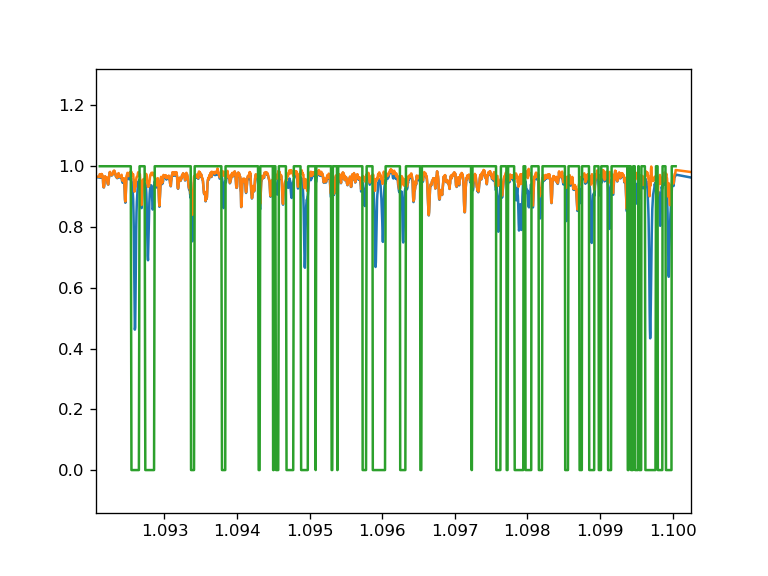

In [64]:
# Example on one order
# --------------------
eniric.atmmodel["base"] = 'mtrans_car-20160325T05h28m38s'
mask = (wave > 1.092) & (wave < 1.100366) & (flux_corr > 0.)
atm = Atmosphere.from_band("Y", bary=False)
atm = atm.at(wave[mask])

# Mask the transmission below given depth. e.g. 2%-5%
atm.mask_transmission(2.0)

# Masking / Correcting the telluric lines
rv_mask_tell = rv_precision(wave[mask], flux_in[mask], mask=atm.mask)
rv_corr_tell = rv_precision(wave[mask], flux_corr[mask])

print('input flux, atm mask: ', rv_mask_tell, ' > masking the tellurics'
      '\ncorr flux, trans mask:', rv_corr_tell, ' > telluric correction')
print('\nQuality')
q_mask_tell = quality(wave[mask], flux_in[mask], mask=atm.mask)
q_corr_tell = quality(wave[mask], flux_corr[mask])
print('input flux, atm mask: ', q_mask_tell, 
      '\ncorr flux, trans mask:', q_corr_tell)

plt.figure()
plt.plot(wave, flux_in)
plt.plot(wave, flux_corr)
plt.xlim(1.092, 1.1002)
plt.plot(atm.wl, atm.mask)

In [ ]:
# Write the transmission file
with open('mtrans_carmenes.txt', 'w') as f:
    for wl, fl in zip(wave, trans):
        f.write("{} {}\n".format(wl,fl))

In [61]:
# Computing RV precision and Quality
# for all orders, bands Y J and K
# --
# Changing the atmospheric model from TAPAS to Molecfit
eniric.atmmodel["base"] = 'mtrans_car-20160325T05h28m38s'
# Defining the bands
bands = ["Y", "J", "H"]
Y_mask = (wave > 0.9996668) & (wave < 1.100366)
J_mask = (wave > 1.16961 ) & (wave < 1.330443)
H_mask = (wave > 1.4995) &  (wave < 1.750583)
band_masks = [Y_mask, J_mask, H_mask]
# Loop over the bands
# plt.figure()
for band, b_mask in zip(bands, band_masks):
    print('\nBand', band, '\n-------')
    print('RV precision')
    # Removing zeros flux points
    mask = b_mask & (flux_corr > 0.)
    atm = Atmosphere.from_band(band, bary=False)
    # Obtain closest telluric model values at the wavelength values (telluric mask is super sampled).
    atm = atm.at(wave[mask])
    # Mask the transmission below given depth. e.g. 2%-5%
    atm.mask_transmission(2.0)
    
    # Masking the telluric lines
    rv_mask_tell = rv_precision(wave[mask], flux_in[mask], mask=atm.mask)
    # Corrected tellurics with Molecfit not weighted by the transmission
    rv_corr_tell = rv_precision(wave[mask], flux_corr[mask])
    print('input flux, atm mask: ', rv_mask_tell, ' > masking the tellurics'
      '\ncorr flux, trans mask:', rv_corr_tell, ' > telluric correction')
    if rv_corr_tell < rv_mask_tell:
        print(cl.green('> RV precision is improved'))
    else:
        print(cl.red('> RV precision is worsen'))
    
    print('\nQuality')
    q_mask_tell = quality(wave[mask], flux_in[mask], mask=atm.mask)
    q_corr_tell = quality(wave[mask], flux_corr[mask])
    print('input flux, atm mask: ', q_mask_tell, 
          '\ncorr flux, trans mask:', q_corr_tell)
    if q_corr_tell > q_mask_tell:
        print(cl.green('> Quality is improved'))
    else:
        print(cl.red('> Quality is worsen'))

    # plt.plot(wave[mask], atm.mask)
    # plt.plot(wave[mask], flux_in[mask])
# plt.axvspan(999.6668, 1100.366, alpha=0.2)
# plt.axvspan(1169.61, 1330.443, alpha=0.2)
# plt.axvspan(1499.5, 1750.583, alpha=0.2)


Band Y 
-------
RV precision
input flux, atm mask:  436.0319293616578 m / s  > masking the tellurics
corr flux, trans mask: 430.4798342579149 m / s  > telluric correction
> RV precision is improved

Quality
input flux, atm mask:  4849.172286413737 
corr flux, trans mask: 4895.178208574486
> Quality is improved

Band J 
-------
RV precision
input flux, atm mask:  665.7126738593307 m / s  > masking the tellurics
corr flux, trans mask: 486.87149763989794 m / s  > telluric correction
> RV precision is improved

Quality
input flux, atm mask:  3267.9870170462436 
corr flux, trans mask: 4377.679133201808
> Quality is improved

Band H 
-------
RV precision
input flux, atm mask:  473.3275292214932 m / s  > masking the tellurics
corr flux, trans mask: 413.67149051606395 m / s  > telluric correction
> RV precision is improved

Quality
input flux, atm mask:  4965.59340134618 
corr flux, trans mask: 5620.729242783238
> Quality is improved


<IPython.core.display.Javascript object>


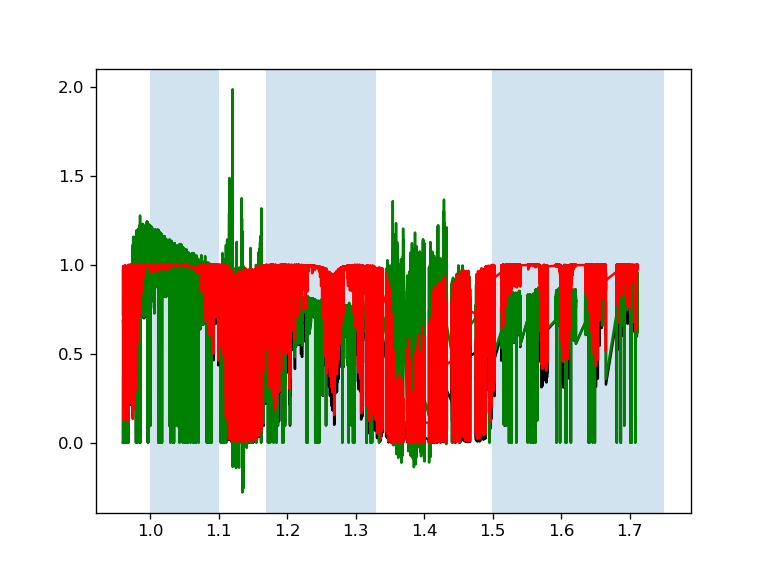

In [65]:
plt.figure()
wl_mask = J_mask
# plt.plot(wave[mask], flux_in[mask])
plt.plot(wave, flux_in, 'k-', label='Input')
plt.plot(wave, flux_corr, 'g-', label='Corrected')
plt.plot(wave, data_tell['mtrans'], 'r-', label='Trans')
plt.axvspan(0.9996668, 1.100366, alpha=0.2)
plt.axvspan(1.16961, 1.330443, alpha=0.2)
plt.axvspan(1.4995, 1.750583, alpha=0.2)
# plt.legend()

In [ ]:
# Problems / Future work
# 1. Need to differentiate between fully corrected lines and not fully corrected lines
# 2. The RV precision is in the 100s of m/s in the paper it's in 10s m/s

In [ ]:
# 1. Excluding not fully corrected telluric lines